# Lista 1

In [3]:
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pypfopt.efficient_frontier import EfficientFrontier
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller

## Questão 1

Vamos buscar pares cointegrados, candidatos a uma estratégia de pairs trading (arbitragem estatística). O teste de Engle-Granger é uma forma de encontrar estes pares. Dadas duas séries temporais X e Y, os passos são os seguintes:

1. Verifique que ambas as séries são I(1).

2. Encontre os coeficientes α e β da regressão linear. `Y = α + βX + ε`

3. Calcule a série temporal de resíduos ε e verifique se ela é I(0). Caso sim, as séries são cointegradas. 

Utilize as séries de preços diários entre o primeiro dia de 2018 e o primeiro dia de 2020. Encontre 3 pares cointegrados com o ativo PETR3 e indique a equação de regressão nestes casos. Plote também os gráficos dos resíduos, incluindo uma linha horizontal com a média dos mesmos. Através de inspeção visual dos mesmos, você acha que uma estratégia de pairs trading nestes pares neste período teria trazido lucro?

In [4]:
# filtra dados
data = pd.read_csv("data/IBOV.csv")
data["Date"] = pd.to_datetime(data["Date"], format="%Y%m%d")
data = data.set_index("Date")

df2018 = data[data.index.year == 2018]
df2019 = data[data.index.year == 2019]

data = df2018.append(df2019)

# separa PETR3
petr3 = data["PETR3"]
petr3 = petr3.values.reshape(-1, 1)
if "PETR3" in data:
    del data["PETR3"]

# remove IBOV da lista
if "IBOV" in data:
    del data["IBOV"]
    

data.head()

,BOVA11,ABEV3,AZUL4,BTOW3,B3SA3,BBAS3,BBSE3,BRML3,BBDC3,BBDC4,...,SANB11,CSNA3,SULA11,SUZB3,TAEE11,TIMP3,TOTS3,USIM5,VALE3,WEGE3
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-02,75.10,20.47,27.15,19.70,21.19,29.57,22.35,11.51,20.15,21.59,...,28.17,8.09,17.51,18.50,17.01,12.40,9.85,9.31,39.06,18.49
2018-01-03,75.30,20.51,27.06,19.54,21.55,29.95,22.36,11.47,20.24,21.69,...,27.94,8.39,18.00,18.36,17.04,12.41,10.06,9.62,38.83,18.21
2018-01-04,76.00,20.40,27.23,20.08,21.69,30.24,22.41,11.61,20.61,22.04,...,28.28,8.65,18.05,18.41,16.77,12.35,10.00,10.17,38.99,18.03
2018-01-05,76.44,20.48,27.20,19.70,22.00,30.24,22.56,11.65,20.61,22.17,...,28.58,8.85,18.10,18.36,16.85,12.46,10.21,9.73,39.59,18.10
2018-01-08,76.76,20.44,26.91,19.54,22.10,30.31,22.69,11.60,20.61,22.16,...,29.08,9.28,17.84,18.80,16.77,12.29,10.21,9.84,40.47,18.25


In [5]:
# filtra apenas séries não estacionárias

stationary = []

for col in data:
    r = adfuller(data[col])
    # filtra p-value com threashold de 0.05
    if r[1] < 0.05:
        stationary.append(col)
        
# remove séries estacionárias
for col in data:
    if col in stationary:
        del data[col]
        
print(f"Séries estacionárias (removidas): {stationary}")
print(f"Séries não estacionárias restantes: {len(data.columns)}")

Séries estacionárias (removidas): ['CIEL3', 'COGN3']
Séries não estacionárias restantes: 68


Ativo: BOVA11
Equação de regressão: Y = -5.788 + 0.362 * X + ε
Média: 4.4390905195560015e-15


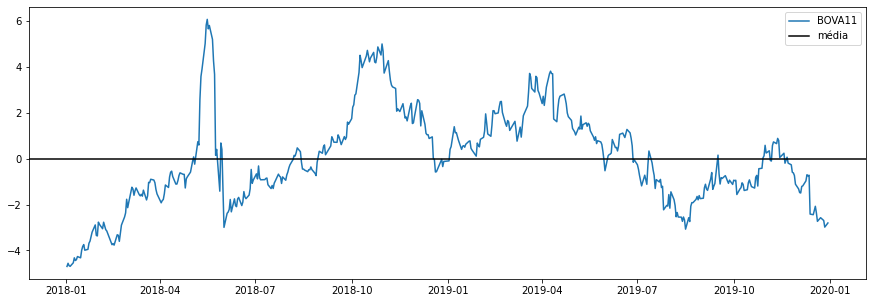

Ativo: AZUL4
Equação de regressão: Y = 14.363 + 0.318 * X + ε
Média: 4.266138940872001e-15


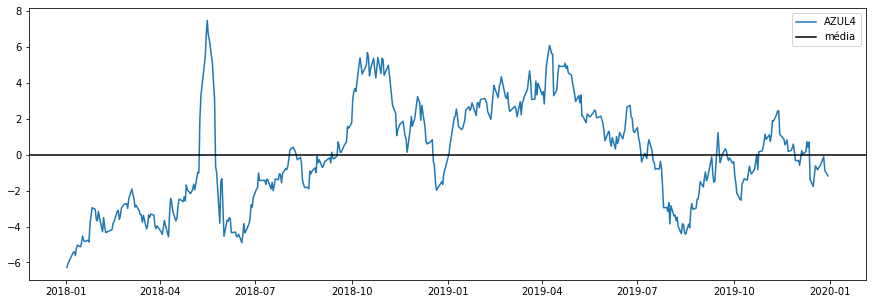

Ativo: B3SA3
Equação de regressão: Y = 14.937 + 0.367 * X + ε
Média: 4.496741045784001e-15


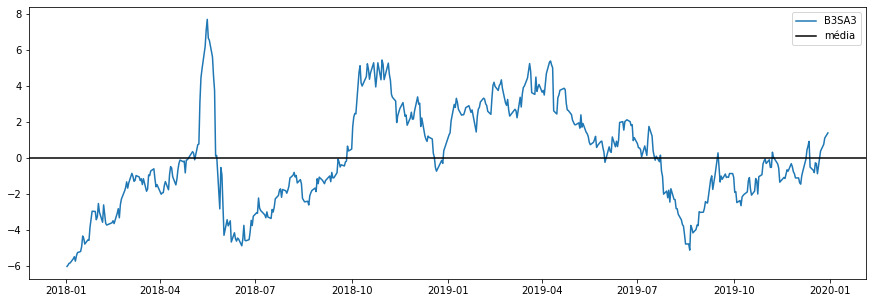

In [6]:
# calcula regressão linear entre PETR3 e outros stocks

MAX_RESULT = 3
result_count = 0

def find_residual(vpetr3, vstock, alpha, beta):
    return vpetr3 - alpha - beta * vstock

for col in data:
    if result_count >= MAX_RESULT:
        break
        
    series = data[col].values.reshape(-1, 1)
    model = LinearRegression().fit(series, petr3)

    alpha = model.intercept_[0]
    beta = model.coef_[0][0]

    # calcula série de resíduos
    residual = []
    for vpetr3, vstock in zip(petr3, series):
        vpetr3 = vpetr3[0]
        vstock = vstock[0]
    
        residual.append(find_residual(vpetr3, vstock, alpha, beta))
    
    # verifica se série é estacionária
    r = adfuller(residual)
    # filtra p-value com threashold de 0.05
    if r[1] < 0.05:
        print(f"Ativo: {col}")
        print(f"Equação de regressão: Y = {alpha:.3f} + {beta:.3f} * X + ε")
        print(f"Média: {np.array(residual).mean()}")
        plt.figure(figsize=(15,5))
        plt.plot(data.index, residual, label=col)
        plt.axhline(np.array(residual).mean(), color='black', label="média")
        plt.legend()
        plt.show()

        result_count += 1

## Questão 2

Nesta questão vamos simular o modelo de Markowitz com rebalanceamento diário e sem recálculo da estratégia. O universo de ativos será composto por todos os ativos disponibilizados (ativos do iBov + BOVA11). Utilize os dados do primeiro dia de 2019 até o primeiro dia de 2020 como in-sample e do primeiro dia de 2020 até o final como out-of-sample. Calcule o μ e Σ através dos dados históricos in-sample. Encontre:

In [7]:
data = pd.read_csv("data/IBOV.csv")
data["Date"] = pd.to_datetime(data["Date"], format="%Y%m%d")
data = data.set_index("Date")

if "IBOV" in data:
    del data["IBOV"]
    
insample = data[data.index.year == 2019]
outofsample = data[data.index.year == 2020]
    
display(insample.head())
display(outofsample.head())

,BOVA11,ABEV3,AZUL4,BTOW3,B3SA3,BBAS3,BBSE3,BRML3,BBDC3,BBDC4,...,SANB11,CSNA3,SULA11,SUZB3,TAEE11,TIMP3,TOTS3,USIM5,VALE3,WEGE3
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-02,87.90,15.74,36.33,42.36,26.49,45.52,24.68,12.59,25.42,28.67,...,41.51,8.59,27.17,38.18,21.89,11.61,9.46,9.51,49.77,17.58
2019-01-03,88.00,15.91,36.37,42.79,27.64,45.71,24.95,12.67,25.95,28.96,...,42.88,8.69,26.44,36.55,21.95,11.54,9.68,9.30,47.74,17.98
2019-01-04,88.50,16.13,36.25,41.37,26.64,45.71,24.70,12.43,25.38,28.73,...,42.84,9.09,25.25,37.16,22.82,11.60,9.95,9.85,50.84,18.19
2019-01-07,88.48,16.06,35.30,39.54,26.50,45.41,24.34,12.35,25.60,29.07,...,43.55,9.11,25.66,35.46,22.56,11.98,9.73,9.87,50.57,17.90
2019-01-08,88.83,15.74,34.72,41.37,26.57,44.90,23.98,12.37,25.88,29.25,...,43.23,9.14,26.25,35.81,22.42,12.43,9.34,9.59,51.06,17.76


,BOVA11,ABEV3,AZUL4,BTOW3,B3SA3,BBAS3,BBSE3,BRML3,BBDC3,BBDC4,...,SANB11,CSNA3,SULA11,SUZB3,TAEE11,TIMP3,TOTS3,USIM5,VALE3,WEGE3
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-02,114.24,19.20,58.80,64.96,44.26,53.06,34.88,18.22,31.95,33.82,...,48.34,14.67,61.21,40.79,29.98,15.67,23.00,9.61,54.33,34.99
2020-01-03,113.80,18.93,56.76,64.08,42.98,52.97,34.49,18.63,31.46,33.83,...,48.34,14.56,63.69,40.65,29.99,15.70,23.49,9.51,53.93,34.55
2020-01-06,112.59,19.02,55.00,63.68,42.57,52.27,35.06,18.50,31.28,33.23,...,47.11,14.20,63.26,40.58,30.02,15.68,22.95,9.33,53.61,34.64
2020-01-07,112.24,19.06,56.82,63.53,43.95,51.87,35.08,18.80,30.74,32.65,...,46.82,14.20,62.41,41.10,29.77,15.85,23.05,9.42,54.00,34.91
2020-01-08,111.95,18.97,56.92,64.37,43.83,51.40,35.06,18.25,30.27,32.15,...,46.39,14.18,62.20,43.15,29.17,16.02,22.74,9.30,54.01,33.58


In [11]:
expected_returns = insample.mean()
display(expected_returns.head())

cov_matrix = insample.cov()
cov_matrix.head()

BOVA11    96.950968
ABEV3     17.651411
AZUL4     44.577379
BTOW3     43.871048
B3SA3     37.758750
dtype: float64

,BOVA11,ABEV3,AZUL4,BTOW3,B3SA3,BBAS3,BBSE3,BRML3,BBDC3,BBDC4,...,SANB11,CSNA3,SULA11,SUZB3,TAEE11,TIMP3,TOTS3,USIM5,VALE3,WEGE3
BOVA11,30.837421,2.824691,37.037694,32.670534,32.380456,2.292118,16.350193,8.519731,5.191465,1.952640,...,3.261057,1.588873,43.541737,-10.619897,10.260425,3.952698,17.780526,-1.329017,2.982211,23.071677
ABEV3,2.824691,0.839966,4.347705,1.662048,3.407637,0.056681,1.825540,0.825824,0.294726,-0.011153,...,0.056578,0.254513,4.625426,-2.382774,1.174066,0.257422,1.648893,-0.246312,-0.585276,1.936055
AZUL4,37.037694,4.347705,54.043323,34.950967,45.328181,-0.207093,21.723564,10.698011,4.451960,0.205355,...,0.794785,3.263385,58.801257,-23.931210,13.545875,4.009735,23.623786,-2.813987,-0.262212,28.090253
BTOW3,32.670534,1.662048,34.950967,76.438016,30.812749,-3.323018,15.841647,10.790938,4.409329,-0.368246,...,6.190354,-9.259193,48.034541,11.010588,9.560614,6.726899,18.918814,-0.308296,0.056671,28.112369
B3SA3,32.380456,3.407637,45.328181,30.812749,44.098966,-2.631023,19.906070,9.054416,3.017573,-0.995206,...,0.017906,2.808117,55.316519,-22.640363,12.181985,2.998894,23.109659,-3.728118,-2.344383,25.137854


**(a)** O portfolio de variância mínima global $p1$. Calcule $μ_{p1}$ e $σ_{p1}$, e plote um gráfico de barras com os pesos de todos os ativos i onde $wi ≥ 0.0001$ ou $wi≤−0.0001$.

In [15]:
a = EfficientFrontier(
    expected_returns=expected_returns, 
    cov_matrix=cov_matrix, 
    weight_bounds=(-0.0001, 0.0001), 
    verbose=True
)

a.min_volatility() 

-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 71, constraints m = 143
          nnz(P) + nnz(A) = 2769
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.00e+00   2.26e+02   1.00e-01   1.31e-03s
 150   1.0000e+30   6.56e-02   2.45e-03   8.43e+01   5.38e-03s

status:               primal infeasible
numb

OptimizationError: Please check your objectives/constraints or use a different solver.

**(b)** O portfolio de variância mínima global, sem shorting, p2. Calcule $μ_{p2}$ e $σ_{p2}$, e plote um gráfico de barras com os pesos de todos os ativos i onde $wi≥0.0001$.

**(c)**  O portfolio eficiente sem shorting e com retorno esperado mínimo 0.3%, p3. Novamente, calcule $μ_{p3}$ e $σ_{p3}$ e plote um gráfico de barras com os pesos de todos os ativos i onde $wi≥0.0001$.

**(d)**  Calcule as séries out-of-sample dos três portfolios assumindo um investimento inicial de R$1. Plote um gráfico comparativo com a performance dos mesmos no período out-of-sample. Inclua também a série do índice iBov -  normalize o iBov para começar de 1.

**(e)**  Calcule o retorno médio e o desvio padrão diários das séries out-of-sample para cada portfolio. Estes valores estão condizentes com os valores calculados in-sample?

## Questão 3

No problema acima, suponha que você quisesse adicionar novas restrições:

**(a)** Nenhum ativo pode ter peso maior que 10% ou menor que -10%.

**(b)** Seja $W⊂N$ o conjunto de ativos que fazem parte do setor de teconologia. Você quer que seu portfolio tenha no máximo 30% em ações deste setor.

Escreva as restrições adicionais que você incluiria no seu modelo para garantir estas condições. Não é necessário resolver o modelo acima com estas restrições adicionais.